<a href="https://colab.research.google.com/github/workingbetter/Optimisation_Project_2/blob/main/Optimisation_3071806.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Maximising a Function

In [86]:
import random
import math

def f(x, y, z):
    return (
        math.exp(math.cos(53 * z))
        + math.sin(43 * math.exp(y))
        + math.exp(math.sin(29 * x))
        + math.sin(67 * math.sin(z))
        + math.cos(math.cos(37 * y))
        - (2 * x ** 2 + y ** 2 + z ** 2) / 4
    )

def random_search(steps):
    xb = random.uniform(-1, 1)
    yb = random.uniform(-1, 1)
    zb = random.uniform(-1, 1)
    fbest = f(xb, yb, zb)

    for _ in range(steps):
        xn = random.uniform(-1, 1)
        yn = random.uniform(-1, 1)
        zn = random.uniform(-1, 1)
        fnew = f(xn, yn, zn)

        if fnew > fbest:
            xb = xn
            yb = yn
            zb = zn
            fbest = fnew

    return (xb, yb, zb), fbest

def hill_climbing(steps, sigma=0.1):
    xb = random.uniform(-1, 1)
    yb = random.uniform(-1, 1)
    zb = random.uniform(-1, 1)
    fbest = f(xb, yb, zb)

    for _ in range(steps):
        xn = xb + random.gauss(0, sigma)
        yn = yb + random.gauss(0, sigma)
        zn = zb + random.gauss(0, sigma)
        fnew = f(xn, yn, zn)

        if fnew > fbest:
            xb = xn
            yb = yn
            zb = zn
            fbest = fnew

    return (xb, yb, zb), fbest

# Set the number of runs and steps
num_runs = 50
num_steps = 10000

# Run both algorithms multiple times and collect results
random_search_results = []
hill_climbing_results = []

for _ in range(num_runs):
    random_search_results.append(random_search(num_steps))
    hill_climbing_results.append(hill_climbing(num_steps))

# Find and print the maximum values for both algorithms
random_search_max = max(random_search_results, key=lambda x: x[1])
hill_climbing_max = max(hill_climbing_results, key=lambda x: x[1])

print(f"Number of runs: {num_runs}")
print(f"Number of steps: {num_steps}")

print("Random search:")
print("Maximum value:", random_search_max[1])
print("Best solution: x =", random_search_max[0][0], ", y =", random_search_max[0][1], ", z =", random_search_max[0][2])

print("\nHill climbing:")
print("Maximum value:", hill_climbing_max[1])
print("Best solution: x =", hill_climbing_max[0][0], ", y =", hill_climbing_max[0][1], ", z =", hill_climbing_max[0][2])


Number of runs: 50
Number of steps: 10000
Random search:
Maximum value: 8.351122094311705
Best solution: x = 0.05066574577501859 , y = 0.2977675151748942 , z = 0.11625179596100743

Hill climbing:
Maximum value: 8.326618882846196
Best solution: x = 0.049803241974865624 , y = 0.29915417887546 , z = -0.3577974169445486


# Part 2: Distribution Network

In [18]:
import sys
import math
import random
import heapq
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.cluster import KMeans
import numpy as np


class Graph:

    def __init__(self, vertices):
        self.vertices = vertices
        self.n = len(vertices)

    def x(self, v):
        return self.vertices[v][0]

    def y(self, v):
        return self.vertices[v][1]

    _d_lookup = {}

    def d(self, u, v):
        if (u, v) in self._d_lookup:
            return self._d_lookup[(u, v)]
        _distance = math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)
        self._d_lookup[(u, v)], self._d_lookup[(v, u)] = _distance, _distance
        return _distance

class Route:

    def __init__(self, g, vertices=None):
        self.g = g
        if vertices is None:
            self.vertices = list(range(1, g.n))
            random.shuffle(self.vertices)
        else:
            self.vertices = vertices
        self.__cost = None

    def cost(self):
        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.d(self.g.vertices[i], self.g.vertices[j])
        return self.__cost

class GeneticAlgorithm:

    def __init__(self, g, population_size, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):
        self.g = g
        self.population = []
        for _ in range(population_size):
            self.population.append(Route(g))
        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate

    def crossover(self, mum, dad):
        size = len(mum.vertices)
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        current_dad_position, current_mum_position = 0, 0
        for i in chain(range(start), range(end + 1, size)):
            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1
            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        return Route(self.g, alice), Route(self.g, bob)

    def mutate(self, route):
        if random.random() < self.mutation_rate:
            for i in range(len(route.vertices)):
                if random.random() < self.mutation_swap_rate:
                    j = random.randrange(len(route.vertices))
                    route.vertices[i], route.vertices[j] = route.vertices[j], route.vertices[i]


    def select_parent(self, k):
        tournament = random.sample(self.population, k)
        return min(tournament, key=lambda route: route.cost())

    def evolve(self):
        new_population = []

        elites = int(self.elite_mating_rate * self.population_size)
        new_population.extend(heapq.nsmallest(elites, self.population, key=lambda route: route.cost()))

        while len(new_population) < self.population_size:
            mum = self.select_parent(self.k)
            dad = self.select_parent(self.k)

            alice, bob = self.crossover(mum, dad)
            self.mutate(alice)
            self.mutate(bob)

            new_population.append(alice)
            new_population.append(bob)

        self.population = new_population

def find_optimal_routes(vertices, n_clusters, n_genetic_iterations, population_size=100):
    g = Graph(vertices)

    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(vertices)

    subgraphs = [[] for _ in range(n_clusters)]
    for i, cluster_label in enumerate(cluster_labels):
        subgraphs[cluster_label].append(vertices[i])

    optimal_routes = []
    for subgraph in subgraphs:
        ga = GeneticAlgorithm(Graph(subgraph), population_size)
        for _ in range(n_genetic_iterations):
            ga.evolve()
        optimal_routes.append(min(ga.population, key=lambda route: route.cost()))

    return optimal_routes






def main():
    vertices = [
        (54.13917237, 10.16301447),
        (5.163117855, 18.37136899),
        (58.10773412, 97.325872),
        (16.60663876, 73.67529068),
        (10.92151473, 26.90262604),
        (40.2830426, 49.00596112),
        (95.90679501, 31.25379214),
        (38.80688537, 61.84963412),
        (50.77362816, 41.71229884),
        (16.12104517, 4.174152112),
        (30.57252604, 25.66416139),
        (88.65418483, 28.60340585),
        (76.15833298, 52.06010201),
        (57.99079029, 58.29016932),
        (80.11801005, 80.74242101),
        (90.87902761, 90.97690565),
        (2.587207522, 45.80849397),
        (74.04980053, 2.986131158),
        (71.70911665, 37.25817058),
        (22.37191714, 94.53074723),
        (24.10112206, 11.06658123),
        (42.27800052, 9.141860385),
        (58.3280586, 76.15907608),
    ]

    n_clusters = 2
    n_genetic_iterations = 1000
    optimal_routes = find_optimal_routes(vertices, n_clusters, n_genetic_iterations)

    for i, route in enumerate(optimal_routes):
        print("Cluster {}: Stores: {} Total cost: {:.2f}".format(i, route.vertices, route.cost()))

if __name__ == "__main__":
    main()




Cluster 0: Stores: [4, 5, 2, 1, 3, 7, 8, 6] Total cost: 193.93
Cluster 1: Stores: [10, 9, 7, 3, 6, 11, 8, 5, 2, 4, 1, 12, 13] Total cost: 309.85


In [9]:
import sys
import math
import random
import heapq
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.cluster import KMeans
import numpy as np


class Graph:

    def __init__(self, vertices):
        self.vertices = vertices
        self.n = len(vertices)

    def x(self, v):
        return self.vertices[v][0]

    def y(self, v):
        return self.vertices[v][1]

    _d_lookup = {}

    def d(self, u, v):
        if (u, v) in self._d_lookup:
            return self._d_lookup[(u, v)]
        _distance = math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)
        self._d_lookup[(u, v)], self._d_lookup[(v, u)] = _distance, _distance
        return _distance

class Route:

    def __init__(self, g, vertices=None):
        self.g = g
        if vertices is None:
            self.vertices = list(range(1, g.n))
            random.shuffle(self.vertices)
        else:
            self.vertices = vertices
        self.__cost = None

    def cost(self):
        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.d(self.g.vertices[i], self.g.vertices[j])
        return self.__cost

class GeneticAlgorithm:

    def __init__(self, g, population_size, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):
        self.g = g
        self.population = []
        for _ in range(population_size):
            self.population.append(Route(g))
        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate

    def crossover(self, mum, dad):
        size = len(mum.vertices)
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        current_dad_position, current_mum_position = 0, 0
        for i in chain(range(start), range(end + 1, size)):
            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1
            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        return Route(self.g, alice), Route(self.g, bob)

    def mutate(self, route):
        if random.random() < self.mutation_rate:
            for i in range(len(route.vertices)):
                if random.random() < self.mutation_swap_rate:
                    j = random.randrange(len(route.vertices))
                    route.vertices[i], route.vertices[j] = route.vertices[j], route.vertices[i]


    def select_parent(self, k):
        tournament = random.sample(self.population, k)
        return min(tournament, key=lambda route: route.cost())

    def evolve(self):
        new_population = []

        elites = int(self.elite_mating_rate * self.population_size)
        new_population.extend(heapq.nsmallest(elites, self.population, key=lambda route: route.cost()))

        while len(new_population) < self.population_size:
            mum = self.select_parent(self.k)
            dad = self.select_parent(self.k)

            alice, bob = self.crossover(mum, dad)
            self.mutate(alice)
            self.mutate(bob)

            new_population.append(alice)
            new_population.append(bob)

        self.population = new_population

def find_optimal_routes(vertices, n_clusters, n_genetic_iterations, population_size=100):
    g = Graph(vertices)

    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(vertices)

    subgraphs = [[] for _ in range(n_clusters)]
    for i, cluster_label in enumerate(cluster_labels):
        subgraphs[cluster_label].append(vertices[i])

    optimal_routes = []
    for subgraph in subgraphs:
        ga = GeneticAlgorithm(Graph(subgraph), population_size)
        for _ in range(n_genetic_iterations):
            ga.evolve()
        optimal_routes.append(min(ga.population, key=lambda route: route.cost()))

    return optimal_routes


def assign_warehouses(optimal_routes, warehouse_positions):
    g = Graph(warehouse_positions)
    warehouse_routes = {i: [] for i in range(len(warehouse_positions))}
    for cluster_idx, route in enumerate(optimal_routes):
        min_distance = float('inf')
        min_warehouse_idx = None
        for warehouse_idx, warehouse in enumerate(warehouse_positions):
            for store in route.vertices:
                distance = g.d(warehouse, route.g.vertices[store])
                if distance < min_distance:
                    min_distance = distance
                    min_warehouse_idx = warehouse_idx
        warehouse_routes[min_warehouse_idx].append(route)
    return warehouse_routes




def main():
    vertices = [
        (54.13917237, 10.16301447),
        (5.163117855, 18.37136899),
        (58.10773412, 97.325872),
        (16.60663876, 73.67529068),
        (10.92151473, 26.90262604),
        (40.2830426, 49.00596112),
        (95.90679501, 31.25379214),
        (38.80688537, 61.84963412),
        (50.77362816, 41.71229884),
        (16.12104517, 4.174152112),
        (30.57252604, 25.66416139),
        (88.65418483, 28.60340585),
        (76.15833298, 52.06010201),
        (57.99079029, 58.29016932),
        (80.11801005, 80.74242101),
        (90.87902761, 90.97690565),
        (2.587207522, 45.80849397),
        (74.04980053, 2.986131158),
        (71.70911665, 37.25817058),
        (22.37191714, 94.53074723),
        (24.10112206, 11.06658123),
        (42.27800052, 9.141860385),
        (58.3280586, 76.15907608),
    ]


    warehouse_positions = [
        (0, 0),
        (100, 100),
    ]

    vehicle_specs = [
        {'type': 'Van', 'cost_per_mile': 1, 'max_stores': 4},
        {'type': 'Lorry', 'cost_per_mile': 2, 'max_stores': 16},
    ]


    n_clusters = 2
    n_genetic_iterations = 1000
    optimal_routes = find_optimal_routes(vertices, n_clusters, n_genetic_iterations, population_size=100)
    warehouse_routes = assign_warehouses(optimal_routes, warehouse_positions)

    total_cost = 0

    for warehouse_idx, routes in warehouse_routes.items():
        print(f"Warehouse {warehouse_idx + 1}:")
        
        vehicle_counts = [0, 0]
        for route in routes:
            route_cost_van = route.cost() * vehicle_specs[0]['cost_per_mile']
            route_cost_lorry = route.cost() * vehicle_specs[1]['cost_per_mile']
            
            if len(route.vertices) <= vehicle_specs[0]['max_stores'] and route_cost_van <= route_cost_lorry:
                vehicle_counts[0] += 1
                route.vehicle_type = vehicle_specs[0]
            else:
                vehicle_counts[1] += 1
                route.vehicle_type = vehicle_specs[1]
        
        for vehicle_idx, vehicle_spec in enumerate(vehicle_specs):
            num_vehicles = vehicle_counts[vehicle_idx]
            print(f"{num_vehicles} {vehicle_spec['type']}s")

        for route in routes:
            cost = route.cost() * route.vehicle_type['cost_per_mile']
            print(f"Route: Stores: {route.vertices}, Total cost: £{cost:.2f}")
            total_cost += cost

    print(f"Total cost: £{total_cost:.2f}")

if __name__ == "__main__":
    main()


Warehouse 1:
0 Vans
1 Lorrys
Route: Stores: [6, 8, 7, 3, 1, 2, 5, 4], Total cost: £387.86
Warehouse 2:
0 Vans
1 Lorrys
Route: Stores: [10, 9, 13, 8, 6, 3, 7, 11, 5, 2, 4, 1, 12], Total cost: £625.32
Total cost: £1013.17


In [44]:
import sys
import math
import random
import heapq
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.cluster import KMeans
import numpy as np


class Graph:

    def __init__(self, vertices, vehicle_type, max_supply):
        self.vertices = vertices
        self.n = len(vertices)
        self.vehicle_type = vehicle_type
        self.max_supply = max_supply

    def x(self, v):
        return self.vertices[v][0]

    def y(self, v):
        return self.vertices[v][1]

    _d_lookup = {}

    def d(self, u, v):
        if (u, v) in self._d_lookup:
            return self._d_lookup[(u, v)]
        _distance = math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)
        self._d_lookup[(u, v)], self._d_lookup[(v, u)] = _distance, _distance
        return _distance


class Route:

    def __init__(self, g, vertices=None, num_vans=0, num_lorries=0):
        self.g = g
        if vertices is None:
            self.vertices = list(range(1, g.n))
            random.shuffle(self.vertices)
        else:
            self.vertices = vertices
        self.num_vans = num_vans
        self.num_lorries = num_lorries
        self.__cost = None

    def cost(self):
        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.d(self.g.vertices[i], self.g.vertices[j])
            self.__cost += self.num_vans * self.g.vehicle_type['van'][0]
            self.__cost += self.num_lorries * self.g.vehicle_type['lorry'][0]
        return self.__cost


class GeneticAlgorithm:

    def __init__(self, g, population_size, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):
        self.g = g
        self.population = []
        for _ in range(population_size):
            self.population.append(Route(g))
        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate

    def crossover(self, mum, dad):
        size = len(mum.vertices)
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        current_dad_position, current_mum_position = 0, 0
        for i in chain(range(start), range(end + 1, size)):
            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1
            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        num_vans_alice = 0
        num_lorries_alice = 0
        for v in alice:
            if v < self.g.max_supply['van']:
                num_vans_alice += 1
            else:
                num_lorries_alice += 1

        num_vans_bob = 0
        num_lorries_bob = 0
        for v in bob:
            if v < self.g.max_supply['van']:
                num_vans_bob += 1
            else:
                num_lorries_bob += 1

        alice_route = Route(self.g, alice, num_vans_alice, num_lorries_alice)
        bob_route = Route(self.g, bob, num_vans_bob, num_lorries_bob)

        return alice_route, bob_route

    def mutate(self, route):
        if random.random() < self.mutation_rate:
            for i in range(len(route.vertices)):
                if random.random() < self.mutation_swap_rate:
                    j = random.randrange(len(route.vertices))
                    route.vertices[i], route.vertices[j] = route.vertices[j], route.vertices[i]

            num_vans = 0
            num_lorries = 0
            for v in route.vertices:
                if v < self.g.max_supply['van']:
                    num_vans += 1
                else:
                    num_lorries += 1

            route.num_vans = num_vans
            route.num_lorries = num_lorries

    def select_parent(self, k):
        tournament = random.sample(self.population, k)
        return min(tournament, key=lambda route: route.cost())

    def evolve(self):
        new_population = []

        elites = int(self.elite_mating_rate * self.population_size)
        new_population.extend(heapq.nsmallest(elites, self.population, key=lambda route: route.cost()))

        while len(new_population) < self.population_size:
            mum = self.select_parent(self.k)
            dad = self.select_parent(self.k)

            alice, bob = self.crossover(mum, dad)
            self.mutate(alice)
            self.mutate(bob)

            new_population.append(alice)
            new_population.append(bob)

        self.population = new_population

def find_optimal_routes(vertices, n_clusters, n_genetic_iterations, population_size=100):
    vehicle_type = {'van': [1.4, 4], 'lorry': [2.16, 16]}

    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(vertices)

    subgraphs = [[] for _ in range(n_clusters)]
    for i, cluster_label in enumerate(cluster_labels):
        subgraphs[cluster_label].append(vertices[i])

    optimal_routes = []
    for i, subgraph in enumerate(subgraphs):
        g = Graph(subgraph, vehicle_type, {'van': 4, 'lorry': 16})
        ga = GeneticAlgorithm(g, population_size)
        for _ in range(n_genetic_iterations):
            ga.evolve()

        optimal_routes.append(min(ga.population, key=lambda route: route.cost()))

        num_vans = optimal_routes[-1].num_vans
        num_lorries = optimal_routes[-1].num_lorries
        while num_vans > g.max_supply['van'] or num_lorries > g.max_supply['lorry']:
            if num_vans > g.max_supply['van'] and num_lorries > g.max_supply['lorry']:
                # If there are too many vans and lorries, remove the most expensive one until we have the correct number
                if vehicle_type['van'][0] > vehicle_type['lorry'][0]:
                    optimal_routes[-1].num_vans -= 1
                else:
                    optimal_routes[-1].num_lorries -= 1
            elif num_vans > g.max_supply['van']:
                # If there are too many vans, remove the most expensive one until we have the correct number
                optimal_routes[-1].num_vans -= 1
            elif num_lorries > g.max_supply['lorry']:
                # If there are too many lorries, remove the most expensive one until we have the correct number
                optimal_routes[-1].num_lorries -= 1

    total_cost = sum(route.cost() for route in optimal_routes)

    return optimal_routes, total_cost


def main():
    vertices = [
        (54.13917237, 10.16301447),
        (5.163117855, 18.37136899),
        (58.10773412, 97.325872),
        (16.60663876, 73.67529068),
        (10.92151473, 26.90262604),
        (40.2830426, 49.00596112),
        (95.90679501, 31.25379214),
        (38.80688537, 61.84963412),
        (50.77362816, 41.71229884),
        (16.12104517, 4.174152112),
        (30.57252604, 25.66416139),
        (88.65418483, 28.60340585),
        (76.15833298, 52.06010201),
        (57.99079029, 58.29016932),
        (80.11801005, 80.74242101),
        (90.87902761, 90.97690565),
        (2.587207522, 45.80849397),
        (74.04980053, 2.986131158),
        (71.70911665, 37.25817058),
        (22.37191714, 94.53074723),
        (24.10112206, 11.06658123),
        (42.27800052, 9.141860385),
        (58.3280586, 76.15907608),
    ]

    n_clusters = 2
    n_genetic_iterations = 1000
    optimal_routes, total_cost = find_optimal_routes(vertices, n_clusters, n_genetic_iterations)

    for i, route in enumerate(optimal_routes):
        print("Cluster {}: Stores: {} Vans: {} Lorries: {} Total cost: {:.2f}".format(i, route.vertices, route.num_vans, route.num_lorries, route.cost()))

    print("Total cost: {:.2f}".format(total_cost))

if __name__ == "main":
    main()


main()


Cluster 0: Stores: [9, 2, 8, 3, 1, 4, 5, 10, 6, 7] Vans: 3 Lorries: 7 Total cost: 295.83
Cluster 1: Stores: [9, 5, 4, 2, 8, 3, 1, 6, 10, 7, 11] Vans: 3 Lorries: 8 Total cost: 273.55
Total cost: 569.38


In [25]:
import sys
import math
import random
import heapq
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.cluster import KMeans
import numpy as np

if sys.version_info < (3, 0):
    sys.exit("""Sorry, requires Python 3.x, not Python 2.x.""")

class Graph:

    def __init__(self, vertices):
        self.vertices = vertices
        self.n = len(vertices)

    def x(self, v):
        return self.vertices[v][0]

    def y(self, v):
        return self.vertices[v][1]

    _d_lookup = {}

    def d(self, u, v):
        if (u, v) in self._d_lookup:
            return self._d_lookup[(u, v)]
        _distance = math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2)
        self._d_lookup[(u, v)], self._d_lookup[(v, u)] = _distance, _distance
        return _distance

class Route:

    def __init__(self, g, vertices=None):
        self.g = g
        if vertices is None:
            self.vertices = list(range(1, g.n))
            random.shuffle(self.vertices)
        else:
            self.vertices = vertices
        self.__cost = None

    def cost(self):
        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.d(self.g.vertices[i], self.g.vertices[j])
        return self.__cost

class GeneticAlgorithm:

    def __init__(self, g, population_size, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):
        self.g = g
        self.population = []
        for _ in range(population_size):
            self.population.append(Route(g))
        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate

    def crossover(self, mum, dad):
        size = len(mum.vertices)
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        current_dad_position, current_mum_position = 0, 0
        for i in chain(range(start), range(end + 1, size)):
            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1
            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        return Route(self.g, alice), Route(self.g, bob)

    def mutate(self, route):
        if random.random() < self.mutation_rate:
            for i in range(len(route.vertices)):
                if random.random() < self.mutation_swap_rate:
                    j = random.randrange(len(route.vertices))
                    route.vertices[i], route.vertices[j] = route.vertices[j], route.vertices[i]


    def mutate(self, route):
        if random.random() < self.mutation_rate:
            for i in range(len(route.vertices)):
                if random.random() < self.mutation_swap_rate:
                    j = random.randrange(len(route.vertices))
                    route.vertices[i], route.vertices[j] = route.vertices[j], route.vertices[i]


    def select_parent(self, k):
        tournament = random.sample(self.population, k)
        return min(tournament, key=lambda route: route.cost())

    def evolve(self):
        new_population = []

        elites = int(self.elite_mating_rate * self.population_size)
        new_population.extend(heapq.nsmallest(elites, self.population, key=lambda route: route.cost()))

        while len(new_population) < self.population_size:
            mum = self.select_parent(self.k)
            dad = self.select_parent(self.k)

            alice, bob = self.crossover(mum, dad)
            self.mutate(alice)
            self.mutate(bob)

            new_population.append(alice)
            new_population.append(bob)

        self.population = new_population

def find_optimal_routes(vertices, n_clusters, n_genetic_iterations, population_size=100):
    g = Graph(vertices)

    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(vertices)

    subgraphs = [[] for _ in range(n_clusters)]
    for i, cluster_label in enumerate(cluster_labels):
        subgraphs[cluster_label].append(vertices[i])

    optimal_routes = []
    for subgraph in subgraphs:
        ga = GeneticAlgorithm(Graph(subgraph), population_size)
        for _ in range(n_genetic_iterations):
            ga.evolve()
        optimal_routes.append(min(ga.population, key=lambda route: route.cost()))

    return optimal_routes

def main():
    vertices = [
        (54.13917237, 10.16301447),
        (5.163117855, 18.37136899),
        (58.10773412, 97.325872),
        (16.60663876, 73.67529068),
        (10.92151473, 26.90262604),
        (40.2830426, 49.00596112),
        (95.90679501, 31.25379214),
        (38.80688537, 61.84963412),
        (50.77362816, 41.71229884),
        (16.12104517, 4.174152112),
        (30.57252604, 25.66416139),
        (88.65418483, 28.60340585),
        (76.15833298, 52.06010201),
        (57.99079029, 58.29016932),
        (80.11801005, 80.74242101),
        (90.87902761, 90.97690565),
        (2.587207522, 45.80849397),
        (74.04980053, 2.986131158),
        (71.70911665, 37.25817058),
        (22.37191714, 94.53074723),
        (24.10112206, 11.06658123),
        (42.27800052, 9.141860385),
        (58.3280586, 76.15907608),
    ]

    n_clusters = 2
    n_genetic_iterations = 1000
    optimal_routes = find_optimal_routes(vertices, n_clusters, n_genetic_iterations)

    for i, route in enumerate(optimal_routes):
        print("Cluster {}: Stores: {} Total cost: {:.2f}".format(i, route.vertices, route.cost()))

if __name__ == "__main__":
    main()



Cluster 0: Stores: [13, 12, 1, 4, 2, 5, 8, 11, 6, 3, 7, 9, 10] Total cost: 309.85
Cluster 1: Stores: [6, 8, 7, 3, 1, 2, 5, 4] Total cost: 193.93


In [21]:
def main():
    vertices = [
        (54.13917237, 10.16301447),
        (5.163117855, 18.37136899),
        (58.10773412, 97.325872),
        (16.60663876, 73.67529068),
        (10.92151473, 26.90262604),
        (40.2830426, 49.00596112),
        (95.90679501, 31.25379214),
        (38.80688537, 61.84963412),
        (50.77362816, 41.71229884),
        (16.12104517, 4.174152112),
        (30.57252604, 25.66416139),
        (88.65418483, 28.60340585),
        (76.15833298, 52.06010201),
        (57.99079029, 58.29016932),
        (80.11801005, 80.74242101),
        (90.87902761, 90.97690565),
        (2.587207522, 45.80849397),
        (74.04980053, 2.986131158),
        (71.70911665, 37.25817058),
        (22.37191714, 94.53074723),
        (24.10112206, 11.06658123),
        (42.27800052, 9.141860385),
        (58.3280586, 76.15907608),
    ]

    n_clusters = 2
    n_genetic_iterations = 1000
    optimal_routes = find_optimal_routes(vertices, n_clusters, n_genetic_iterations)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the stores and warehouses
    ax.scatter([v[0] for v in vertices], [v[1] for v in vertices], c='blue', label='Stores')
    ax.scatter([v[0] for v in [vertices[-2], vertices[-1]]], [v[1] for v in [vertices[-2], vertices[-1]]], c='red', label='Warehouses')

    # Plot the routes for each cluster
    colors = ['green', 'orange', 'purple', 'cyan', 'magenta', 'pink', 'brown', 'gray', 'olive', 'teal']
    for i, route in enumerate(optimal_routes):
        cluster_vertices = [vertices[store] for store in route.vertices]
        cluster_vertices.append(vertices[-2])
        cluster_vertices.insert(0, vertices[-1])
        x = [v[0] for v in cluster_vertices]
        y = [v[1] for v in cluster_vertices]
        ax.plot(x, y, linewidth=2, c=colors[i % len(colors)], label='Cluster {}'.format(i))

    # Set the labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    plt.show()


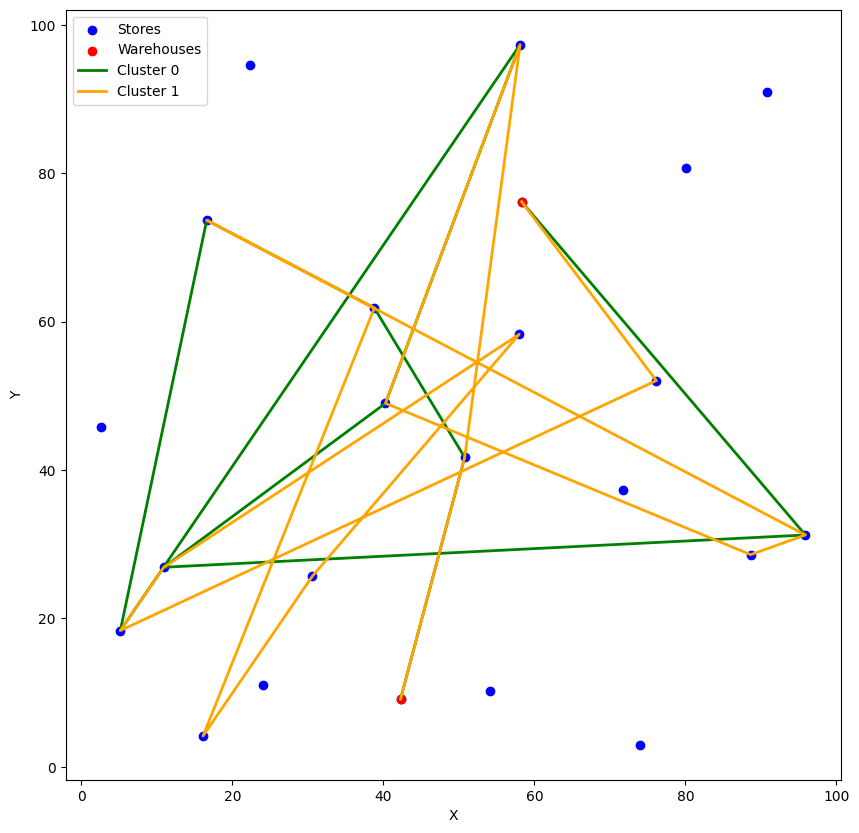

In [22]:
if __name__ == "__main__":
    main()
